In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [2]:
def load_and_preprocess_data():
    """Load and preprocess the California housing dataset."""
    # Load the dataset
    california_housing = fetch_california_housing(as_frame=True)
    X = california_housing.data
    y = california_housing.target

    # Print initial data info
    print("\nInitial Data Info:")
    print("-" * 30)
    print("Dataset shape:", X.shape)
    print("\nMissing values:")
    print(X.isnull().sum())

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Handle outliers in target variable
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print("\nOutlier Analysis:")
    print("-" * 30)
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    print(f"Outliers: {sum((y < lower_bound) | (y > upper_bound))} ({sum((y < lower_bound) | (y > upper_bound))/len(y)*100:.2f}%)")

    # Clip outliers
    y_clean = np.clip(y, lower_bound, upper_bound)

    # Convert target to dollars for alternative scale
    y_dollars = y_clean * 100000

    return X_imputed, y_clean, y_dollars

In [3]:
def split_data(X, y, y_dollars, test_size=0.2, val_size=0.2):
    """Split data into train, validation and test sets."""
    # Split for original scale
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, random_state=42
    )

    # Split for dollar scale
    _, _, y_dollars_train_val, y_dollars_test = train_test_split(
        X, y_dollars, test_size=test_size, random_state=42
    )

    _, _, y_dollars_train, y_dollars_val = train_test_split(
        X_train_val, y_dollars_train_val, test_size=val_size_adjusted, random_state=42
    )

    print("\nDataset Splits:")
    print("-" * 30)
    print(f"Training: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples")
    print(f"Test: {X_test.shape[0]} samples")

    return (X_train, X_val, X_test,
            y_train, y_val, y_test,
            y_dollars_train, y_dollars_val, y_dollars_test)


In [4]:
def train_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test,
                      y_dollars_train, y_dollars_val, y_dollars_test):
    """Train models and evaluate on both scales."""
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train model for original scale (100k$)
    model = Ridge(alpha=0.1, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions (original scale)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Train model for dollar scale
    model_dollars = Ridge(alpha=0.1, random_state=42)
    model_dollars.fit(X_train_scaled, y_dollars_train)

    # Make predictions (dollar scale)
    y_dollars_train_pred = model_dollars.predict(X_train_scaled)
    y_dollars_val_pred = model_dollars.predict(X_val_scaled)
    y_dollars_test_pred = model_dollars.predict(X_test_scaled)

    # Evaluate original scale (100k$)
    print("\nModel Performance (Scale: $100,000):")
    print("-" * 30)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Train RMSE: {train_rmse:.4f} ($100,000)")
    print(f"Val RMSE: {val_rmse:.4f} ($100,000)")
    print(f"Test RMSE: {test_rmse:.4f} ($100,000)")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Val R²: {val_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Evaluate dollar scale
    print("\nModel Performance (Scale: $):")
    print("-" * 30)
    train_rmse_dollars = np.sqrt(mean_squared_error(y_dollars_train, y_dollars_train_pred))
    val_rmse_dollars = np.sqrt(mean_squared_error(y_dollars_val, y_dollars_val_pred))
    test_rmse_dollars = np.sqrt(mean_squared_error(y_dollars_test, y_dollars_test_pred))

    train_r2_dollars = r2_score(y_dollars_train, y_dollars_train_pred)
    val_r2_dollars = r2_score(y_dollars_val, y_dollars_val_pred)
    test_r2_dollars = r2_score(y_dollars_test, y_dollars_test_pred)

    print(f"Train RMSE: ${train_rmse_dollars:.2f}")
    print(f"Val RMSE: ${val_rmse_dollars:.2f}")
    print(f"Test RMSE: ${test_rmse_dollars:.2f}")
    print(f"Train R²: {train_r2_dollars:.4f}")
    print(f"Val R²: {val_r2_dollars:.4f}")
    print(f"Test R²: {test_r2_dollars:.4f}")

    # Plot predictions
    plt.figure(figsize=(12, 5))

    # Original scale plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Price ($100,000)')
    plt.ylabel('Predicted Price ($100,000)')
    plt.title('Predictions in $100,000')
    plt.legend()
    plt.grid(True)

    # Dollar scale plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_dollars_test, y_dollars_test_pred, alpha=0.5)
    plt.plot([y_dollars_test.min(), y_dollars_test.max()],
             [y_dollars_test.min(), y_dollars_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title('Predictions in $')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, test_rmse, test_rmse_dollars, test_r2

In [5]:
def plot_feature_importance(model, feature_names):
    """Plot feature importance."""
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    })
    importance = importance.sort_values('Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Coefficient'])
    plt.title('Feature Importance')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.show()

    return importance

Loading and preprocessing data...

Initial Data Info:
------------------------------
Dataset shape: (20640, 8)

Missing values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Outlier Analysis:
------------------------------
Lower bound: -0.98
Upper bound: 4.82
Outliers: 1071 (5.19%)

Splitting data...

Dataset Splits:
------------------------------
Training: 12384 samples
Validation: 4128 samples
Test: 4128 samples

Training and evaluating model...

Model Performance (Scale: $100,000):
------------------------------
Train RMSE: 0.7042 ($100,000)
Val RMSE: 0.7153 ($100,000)
Test RMSE: 0.7358 ($100,000)
Train R²: 0.6109
Val R²: 0.6125
Test R²: 0.5718

Model Performance (Scale: $):
------------------------------
Train RMSE: $70420.07
Val RMSE: $71526.30
Test RMSE: $73579.11
Train R²: 0.6109
Val R²: 0.6125
Test R²: 0.5718


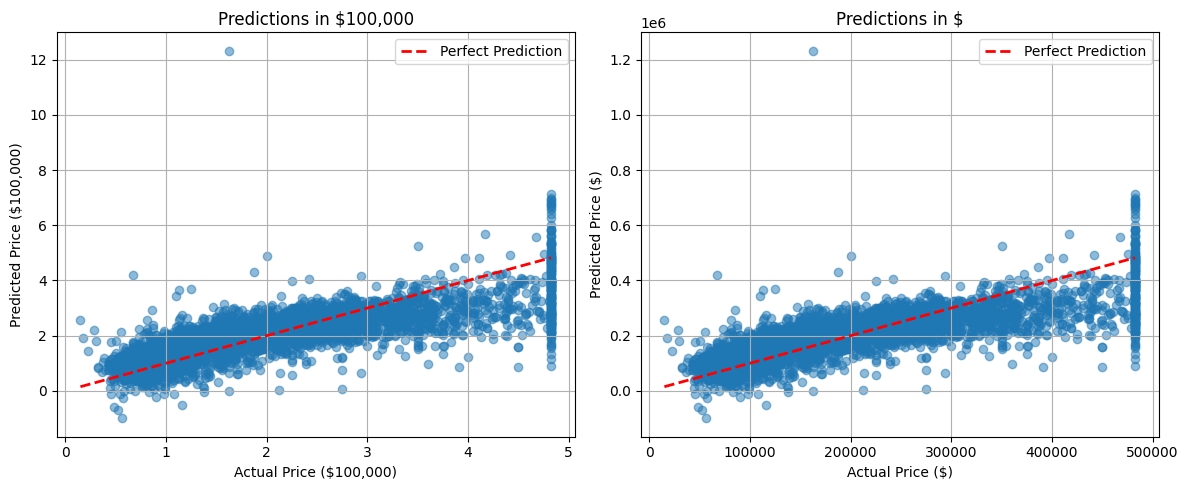


Feature Importance:
------------------------------


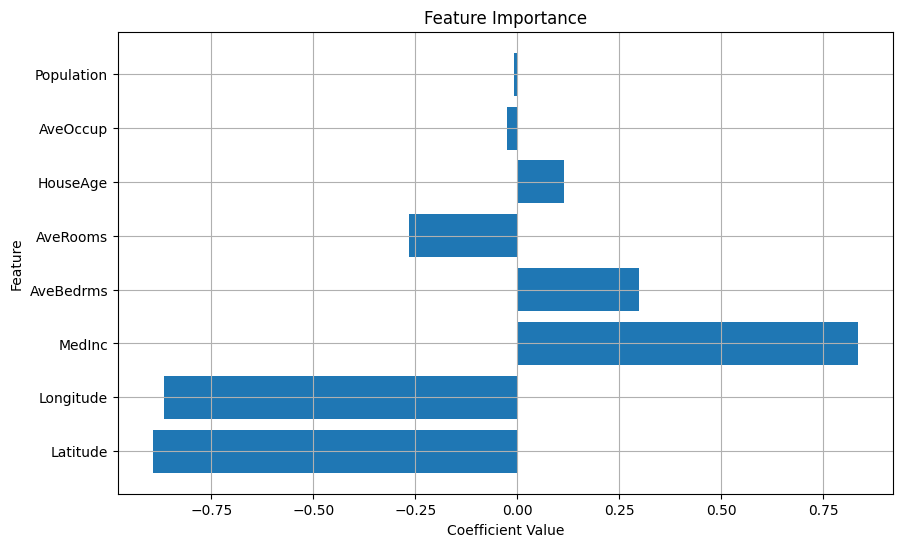

      Feature  Coefficient
6    Latitude    -0.892971
7   Longitude    -0.866018
0      MedInc     0.834681
3   AveBedrms     0.298747
2    AveRooms    -0.265325
1    HouseAge     0.114544
5    AveOccup    -0.025634
4  Population    -0.008491


In [6]:
def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y, y_dollars = load_and_preprocess_data()

    # Split data
    print("\nSplitting data...")
    (X_train, X_val, X_test,
     y_train, y_val, y_test,
     y_dollars_train, y_dollars_val, y_dollars_test) = split_data(X, y, y_dollars)

    # Train and evaluate model
    print("\nTraining and evaluating model...")
    model, test_rmse, test_rmse_dollars, test_r2 = train_and_evaluate(
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        y_dollars_train, y_dollars_val, y_dollars_test
    )

    # Plot feature importance
    print("\nFeature Importance:")
    print("-" * 30)
    importance = plot_feature_importance(model, X.columns)
    print(importance)

if __name__ == "__main__":
    main()